# PyWR

#### Loading required libraries

In [13]:
import warnings
#Suppressing warning message due to deprecation of certain functionality
warnings.filterwarnings("ignore", module="Numba")

import xarray as xr
import numpy as np
import pandas as pd

from scipy.linalg import norm, orthogonal_procrustes
from scipy.spatial import procrustes
from math import atan, sin, cos

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as mcolors

from scipy import interpolate
import matplotlib.path as mpath
import string
# key PyWR functions are imported here
from PyWR import *

### Defining constants 

#### This workbook example uses coordinates for the United States (Note: reanalysis domain needs to be slightly larger than model domain for procrustes analysis to avoid NaNs after interpolation)



In [2]:
# Spatial domain for reanalysis dataset (used to calculate WTs)
nla=55  	# Northernmost latitude
sla=20  	# Southernmost latitude
wlo=-140 	# Westernmost longitude
elo=-100 	# Easternmost longitude

#Spatial domain for model dataset (used for comparison in procrustes analysis)
nlam=53  	# Northernmost latitude
slam=22  	# Southernmost latitude
wlom=-138 	# Westernmost longitude
elom=-102 	# Easternmost longitude

#Time domain:
season='Jan-Dec'
yeari= 1982
yeare= 2010
#Indicate if force download all data (True in case it's corrupted or new one is needed)
force=False

##### Indicate model to process for procrustes analysis (Available options: HadGEM2-A   CNRM-CM5   GFDL_CM3   IPSL_CM5A-LR   CanAM4   NorESM1-M )

In [3]:
model='CNRM-CM5'
smooth='SingleDay'  #choose between 'SingleDay'(no smoothing) and '5DayAVG' (smoothing)

# Prepare and Download Data (if needed)

##### This section downloads data (as needed; details below).

##### Important: some of the datasets are huge. If the data is already downloaded and ok (e.g., not corrupted) but we wanted to re-download it, set `force_download=True` (each dataset can be controlled independently below as an input to do download_data() function, or simultaneuously by defining the variable above).

##### First, let's create a `data` and a `figs` folder. If already there, it won't create anything.

In [4]:
!mkdir -p WUS
!cd WUS
!mkdir -p WUS/data/
!mkdir -p figs

##### To download data from the IRI data library, you need an authentication key. This is stored in a file called `.IRIDLAUTH`, but is not part of the GitHub repository -- you need to contact the IRI Data Library to request access. Once you have done so, you can put your own authentication key in a file called `.IRIDLAUTH` and use this code. This is a moderately annoying step, and we apologize, but it is required by the S2S Database Terms and Conditions and is necessary for us to share all our code while maintaining some security.

##### Set the variable `IRIDLAUTH` to the path where your .IRIDLAUTH file is located.
##### **NB** if you're using `git`, be sure to add `.IRIDLAUTH` to your `gitignore` file if you put the file inside your branch.

In [5]:
IRIDLAUTH = "/Users/drewr/"
with open(f'{IRIDLAUTH}.IRIDLAUTH') as file:
   authkey = file.read() 

# Reanalysis and Observation data

##### Here we download all the data needed, using the spatial and temporal domains defined above. We download the physical field used to build the weather types (geopotential height anomalies at 500 mb in this case), winds (500 mb), rainfall and temperature fields. A 5-day moving average is applied to the fields before computing the daily anomalies (daily climatologies are computed via the naïve approach).

In [6]:
reanalysis = download_data(
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(3%20Sep%202017)/VALUE/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/hdate/(1997)/(2016)/RANGE/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202019-01-01)/streamgridunitconvert/S//units//days/def/L/0.5/add/hdate/add/add//pointwidth/1/def/SOURCES/.ECMWF/.ERA-Interim/.SIX-HOURLY/.pressure_level/.z500/T/3/shiftGRID/T/24/boxAverage/T/2/index/.units/streamgridunitconvert/exch/%5BT%5Dsample-along/c%3A/9.81/(m%20s-2)/%3Ac/div/S/removeGRID/L/5/runningAverage/%5BX/Y%5D/1.0/0./regridLinear/dup/%5Bhdate%5Daverage/2/RECHUNK/sub/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NASA/.NCCS_Dataserver/.CREATE_REANALYSIS/.MERRA2/.day/.atmos/.zg/plev/500/VALUE/plev/removeGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/-0.875/shiftGRID/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/data.nc',
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.phi/P/(500)/VALUE/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/T//pointwidth/0/def/pop/T/-.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/-0.5/shiftGRID/data.nc',
    outfile='WUS/data/hgt_NNRP_rean.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])
reanalysis=reanalysis.isel(P=0)
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 255, time: 10588)
Coordinates:
    P        int32 500
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 20.0 20.0 20.0 20.0 20.0 ... 55.0 55.0 55.0 55.0
  - X        (grid) float64 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
Data variables:
    adif     (time, grid) float32 13.86 15.0 16.79 ... -92.83 -77.81 -59.26

In [7]:
rainfall = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/%28%201%20Jan%20'+str(yeari)+'%29/%2830%20Dec%20'+str(yeare)+'%29/RANGEEDGES/T//pointwidth/0/def/0./shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/-0.5/shiftGRID/data.nc',
    outfile='WUS/data/rainfall_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])
rainfall

<xarray.Dataset>
Dimensions:  (grid: 5904, time: 10588)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 19.75 19.75 19.75 19.75 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -140.2 -139.8 -139.2 -138.8 ... -100.8 -100.2 -99.75
Data variables:
    adif     (time, grid) float32 nan nan nan nan ... -0.4358 -0.4301 -0.4228

In [8]:
t2m  = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/T/(Jan-Dec%201985-2015)/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample%5BYR%5Daverage/T/sampleDOY/sub/data.nc',
    outfile='WUS/data/t2m_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])

# Dimension Reduction

##### We need to choose a percentage of variance explained that we will require as an input to get number of EOFs:

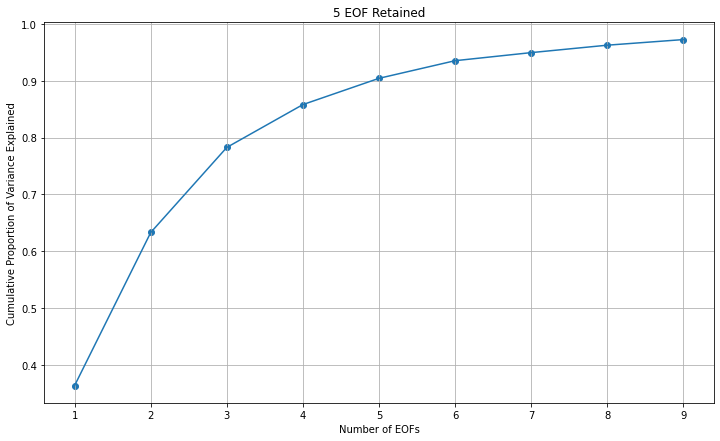

In [9]:
n_eof = get_number_eof(X=reanalysis['adif'].values, var_to_explain=0.9, plot=True)

##### Now we project the data onto the leading EOFs to get the principal component time series.
##### We will retain the PCA model for use later.
##### The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [10]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['adif'].values)
reanalysis_pc = pca_model.transform(reanalysis['adif'].values)

# Reanalysis Weather Typing

##### Now we perform the clustering.
##### We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [11]:
ncluster = 6 # use this number of WTs
n_sim = 25 # typically 25-50 -- try 25 for quick preliminary computation only

##### Now we can use this to run the classifiability index on our centroids.

In [14]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print('The classifiability index is {}'.format(class_idx))

The classifiability index is 1.0


##### Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
##### To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [13]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

#### Start with the reanalysis

In [14]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    model_clust, 
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['adif']
reanalysis_composite['M'] = 0

wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)

wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
#If the WTs start at 0, this line of code shifts them so they start at 1
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1
wt_anomalies

<xarray.DataArray 'adif' (M: 1, WT: 6, Y: 15, X: 17)>
array([[[[-3.45428753e+00, -3.36108446e+00, -3.34408355e+00, ...,
           3.96528840e+00,  4.71353483e+00,  5.27820683e+00],
         [-3.46867275e+00, -3.82517481e+00, -4.40623760e+00, ...,
           4.51088524e+00,  6.01171732e+00,  7.29864502e+00],
         [-2.35008550e+00, -3.50187874e+00, -5.07325125e+00, ...,
           3.49035263e+00,  6.09055376e+00,  8.51475716e+00],
         ...,
         [ 3.95627937e+01,  1.90520859e+01, -2.94853854e+00, ...,
          -6.91712799e+01, -5.85099106e+01, -4.69822464e+01],
         [ 3.43409882e+01,  1.58664665e+01, -3.57753110e+00, ...,
          -6.51972809e+01, -5.62410126e+01, -4.63808250e+01],
         [ 2.74984035e+01,  1.19537392e+01, -4.16273928e+00, ...,
          -5.85619240e+01, -5.16556740e+01, -4.38245049e+01]],

        [[-4.48198414e+00, -3.75309300e+00, -2.79435635e+00, ...,
          -1.82694864e+00, -1.62381434e+00, -1.45257103e+00],
         [-4.40884066e+00, -3.11547971e+00, -1.54849207e+00, ...,
          -1.94754362e+00, -2.10392880e+00, -2.28704882e+00],
         [-3.84589720e+00, -1.78688395e+00,  5.94038308e-01, ...,
          -1.37031436e+00, -2.11813521e+00, -2.96352601e+00],
...
          -1.38588476e+01, -1.14533138e+01, -8.98772621e+00],
         [-5.96583633e+01, -5.94964447e+01, -5.79006386e+01, ...,
          -1.78971004e+01, -1.46952839e+01, -1.15145540e+01],
         [-6.32888222e+01, -6.32321625e+01, -6.17647476e+01, ...,
          -1.95742493e+01, -1.59321356e+01, -1.24198408e+01]],

        [[ 3.63403583e+00,  3.31560326e+00,  3.02734184e+00, ...,
          -9.67126071e-01, -1.58968008e+00, -2.20969915e+00],
         [ 1.54665744e+00,  1.35085905e+00,  1.35640180e+00, ...,
          -7.60627806e-01, -1.72799647e+00, -2.79054284e+00],
         [-2.53913522e+00, -2.46792030e+00, -2.02660966e+00, ...,
           4.48264241e-01, -9.88905132e-01, -2.68280721e+00],
         ...,
         [-4.90996284e+01, -3.90808601e+01, -2.63631172e+01, ...,
           8.08956375e+01,  7.69901276e+01,  7.11561813e+01],
         [-3.51851196e+01, -2.55478630e+01, -1.38722315e+01, ...,
           7.95386963e+01,  7.55280991e+01,  6.96942825e+01],
         [-2.12327099e+01, -1.26847572e+01, -2.72768760e+00, ...,
           7.31469116e+01,  6.92935257e+01,  6.38909569e+01]]]],
      dtype=float32)
Coordinates:
    P        int32 500
  * WT       (WT) int64 1 2 3 4 5 6
  * Y        (Y) float64 20.0 22.5 25.0 27.5 30.0 ... 45.0 47.5 50.0 52.5 55.0
  * X        (X) float64 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
  * M        (M) int64 0

#### Now we prepare a figure with rainfall and temperature composites.

In [15]:
X, Y = np.meshgrid(reanalysis['adif'].X, reanalysis['adif'].Y)
map_proj = ccrs.PlateCarree() #ccrs.Orthographic(-110, 10)
data_proj = ccrs.PlateCarree()
wt_unique = np.unique(wt_anomalies['WT'])
figsize = (14, 8)

In [16]:
#WT proportions
wt=weather_types.to_dataframe(name='WT')
wt=wt+1
wt_counts = wt.groupby('WT').size().div(wt['WT'].size)
wt_counts

WT
1    0.153287
2    0.123158
3    0.126369
4    0.183699
5    0.220060
6    0.193427
dtype: float64

Uncomment the second to last line of the following code block to save the figure.

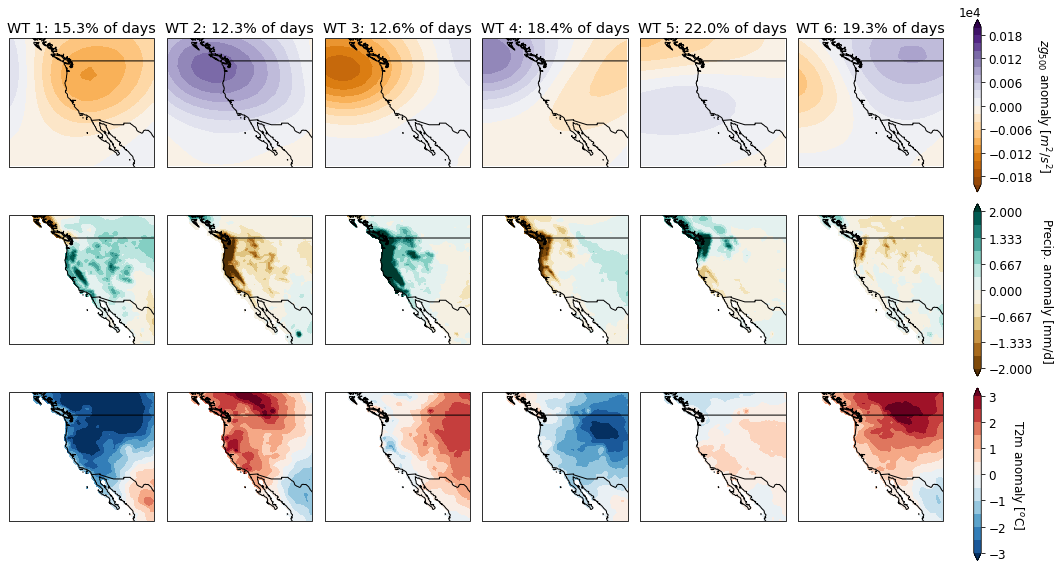

In [17]:
xmin,xmax = reanalysis['X'].min(), reanalysis['X'].max()
ymin,ymax = reanalysis['Y'].min(), reanalysis['Y'].max()

# Set up the Figure
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(
        nrows=3, ncols=len(wt_unique), subplot_kw={'projection': map_proj}, 
        figsize=figsize, sharex=True, sharey=True
    )

# Loop through
for i,w in enumerate(wt_unique):
    def selector(ds):
        times = wt.loc[wt['WT'] == w].index
        typ = np.in1d(ds.unstack('time')['T'], times)
        ds = ds.sel(time = np.in1d(ds.unstack('time')['T'], times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Top row: geopotential height anomalies
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(w, wt_counts.values[i]))
    C0 = selector(reanalysis['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap='PuOr',
        extend="both",
        levels=np.linspace(-2e2, 2e2, 21),
        add_colorbar=False, #could also make these function inputs so users could specify? but optional inputs
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)

    # Middle row: rainfall anomalies
    ax = axes[1, i]
    C1 = selector(rainfall['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'BrBG',
        extend="both",
        levels=np.linspace(-2, 2, 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -75, -9, 5])

    #Bottom row: tepmperature anomalies
    ax = axes[2, i]
    C2 = selector(t2m['asum']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'RdBu_r',
        extend="both",
        levels=np.linspace(-3, 3, 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -70, -9, 5])
    ax.tick_params(colors='b')

# # Add Colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cax0 = fig.add_axes([0.97, 0.65, 0.0075, 0.3])
cax1 = fig.add_axes([0.97, 0.33, 0.0075, 0.3])
cax2 = fig.add_axes([0.97, 0.01, 0.0075, 0.3])
cbar0 = fig.colorbar(C0, cax = cax0)
cbar0.formatter.set_powerlimits((4, 4))
cbar0.update_ticks()
cbar0.set_label(r'$zg_{500}$ anomaly [$m^2$/$s^2$]', rotation=270)
cbar0.ax.get_yaxis().labelpad = 20
cbar1 = fig.colorbar(C1, cax=cax1)
cbar1.set_label('Precip. anomaly [mm/d]', rotation=270)
cbar1.ax.get_yaxis().labelpad = 20
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label('T2m anomaly [$^o$C]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 20

#fig.savefig('figs/wt_composite.pdf', bbox_inches='tight')
plt.show()

# Procrustes Analysis

##### This section shows an example of the procrustes analysis callibration and decomposition using pre-calculated datasets.

## Read data

##### Specify OpenDAP link to IRIDL location of the reanalysis and model WTs.

In [18]:
#url for reanalysis
urlr = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.Obs/.'+ smooth +'/.MERRA/.WT/Y/%28'+str(sla)+'%29/%28'+str(nla)+'%29/RANGE/X/%28'+str(wlo)+'%29/%28'+str(elo)+'%29/RANGE/dods'
WTrea = np.squeeze(xr.open_dataset(urlr,decode_times=False))

print (WTrea)

<xarray.Dataset>
Dimensions:  (X: 17, Y: 15, wt: 7)
Coordinates:
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
    T        float32 2.5
  * Y        (Y) float32 20.0 22.5 25.0 27.5 30.0 ... 45.0 47.5 50.0 52.5 55.0
  * X        (X) float32 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


In [19]:
#url for model
urlm = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.amip/.'+ smooth +'/.PRCP/.'+ model +'/.WT/Y/%28'+str(slam)+'%29/%28'+str(nlam)+'%29/RANGE/X/%28'+str(wlom)+'%29/%28'+str(elom)+'%29/RANGE/dods'
WTmod = np.squeeze(xr.open_dataset(urlm,decode_times=False))

print (WTmod)

<xarray.Dataset>
Dimensions:  (X: 28, Y: 24, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float32 21.71 23.11 24.51 25.91 ... 49.73 51.13 52.53 53.93
  * X        (X) float32 -139.2 -137.8 -136.4 -135.0 ... -104.1 -102.7 -101.2
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


## Spatial interpolation

##### Here we interpolate the model reanalysis WT grid to the model one, to have a fair comparison.


In [20]:
WTrea=WTrea.interp_like(WTmod)
WTrea

<xarray.Dataset>
Dimensions:  (X: 28, Y: 24, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float64 21.71 23.11 24.51 25.91 ... 49.73 51.13 52.53 53.93
  * X        (X) float64 -139.2 -137.8 -136.4 -135.0 ... -104.1 -102.7 -101.2
Data variables:
    WT       (wt, Y, X) float64 20.89 20.88 20.72 20.51 ... -113.5 -122.4 -131.1
Attributes:
    Conventions:  IRIDL

#### Plot reanalysis versus model contour maps for compairson between WTs

##### Reanalysis is set to the default `reanalysis='MERRA'` which is the data downloaded from the example URL. Set `savefig=True` to save the plot. See function documentation for more information on function parameters.

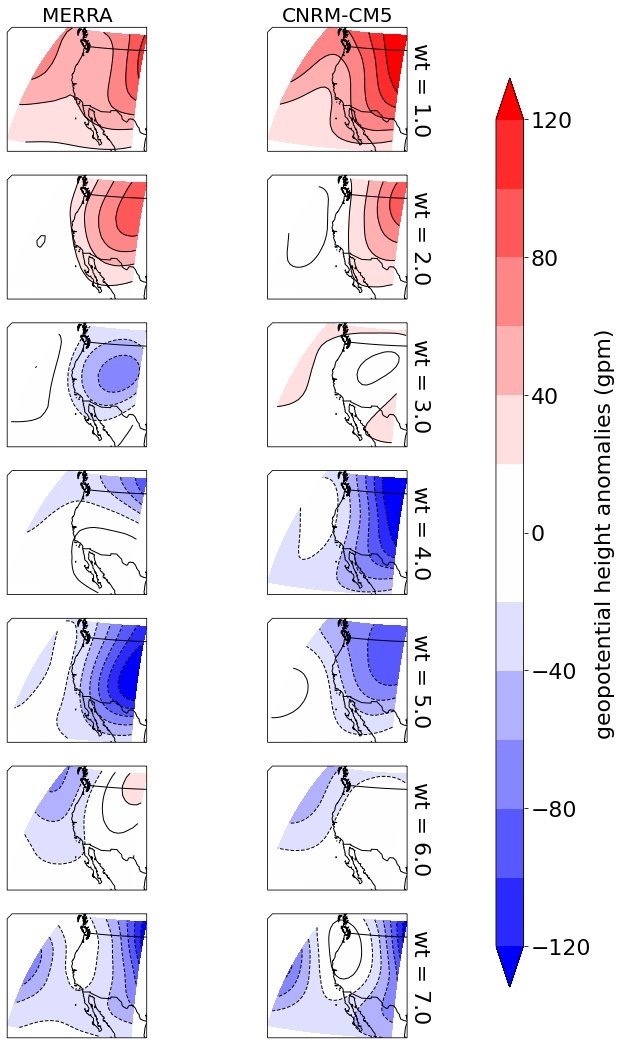

In [21]:
plot_reaVSmod(WTmod,WTrea,model,reanalysis='MERRA',savefig=False)

## Procrustes Analysis

Run the function which performs the procrustes analysis and returns two objects (from function documentation):
1. WTf : Dataframe which includes model, reanalysis, and adjusted reanalysis WT data.
2. Procrustes : Dataframe which includes model data and procrustes analysis with components of scale, rotation, translation.

Set `printDisparity='True'` to see the disparity values calculated by the two different procrustes function defined in the function documentation (`procrustes2()` and `procrustes2d()`)

In [22]:
WTf, procrustes = procrustesAnalysis(WTmod,WTrea,model,reanalysis='MERRA',smooth=smooth,printDisparity=False)

In [23]:
WTf

<xarray.Dataset>
Dimensions:  (X: 28, Y: 24, dataset: 3, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float64 21.71 23.11 24.51 25.91 ... 49.73 51.13 52.53 53.93
  * X        (X) float64 -139.2 -137.8 -136.4 -135.0 ... -104.1 -102.7 -101.2
  * dataset  (dataset) object 'MERRA' 'CNRM-CM5' 'CNRM-CM5 (Procrustes)'
Data variables:
    WT       (dataset, wt, Y, X) float64 20.89 20.88 20.72 ... -98.7 -102.5
Attributes:
    Conventions:  IRIDL

In [24]:
procrustes

<xarray.Dataset>
Dimensions:  (X: 28, Y: 24, dataset: 4, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float32 21.71 23.11 24.51 25.91 ... 49.73 51.13 52.53 53.93
  * X        (X) float32 -139.2 -137.8 -136.4 -135.0 ... -104.1 -102.7 -101.2
  * dataset  (dataset) object 'CNRM-CM5' 'Scaled' 'Rotated' 'Translated'
Data variables:
    WT       (dataset, wt, Y, X) float64 21.13 21.47 21.83 ... -161.7 -181.9
Attributes:
    Conventions:  IRIDL

## Plot Procrustes callibration comparison plots

##### We use the function which prints a comparison plot showing the original model data, reanalysis data, and corrected reanalysis data. This plot uses the `WTf` dataframe which was an output of the `procrustesAnalysis()` function.

##### Set `savefig=True` to save the plot. See function documentation for more information on function parameters.

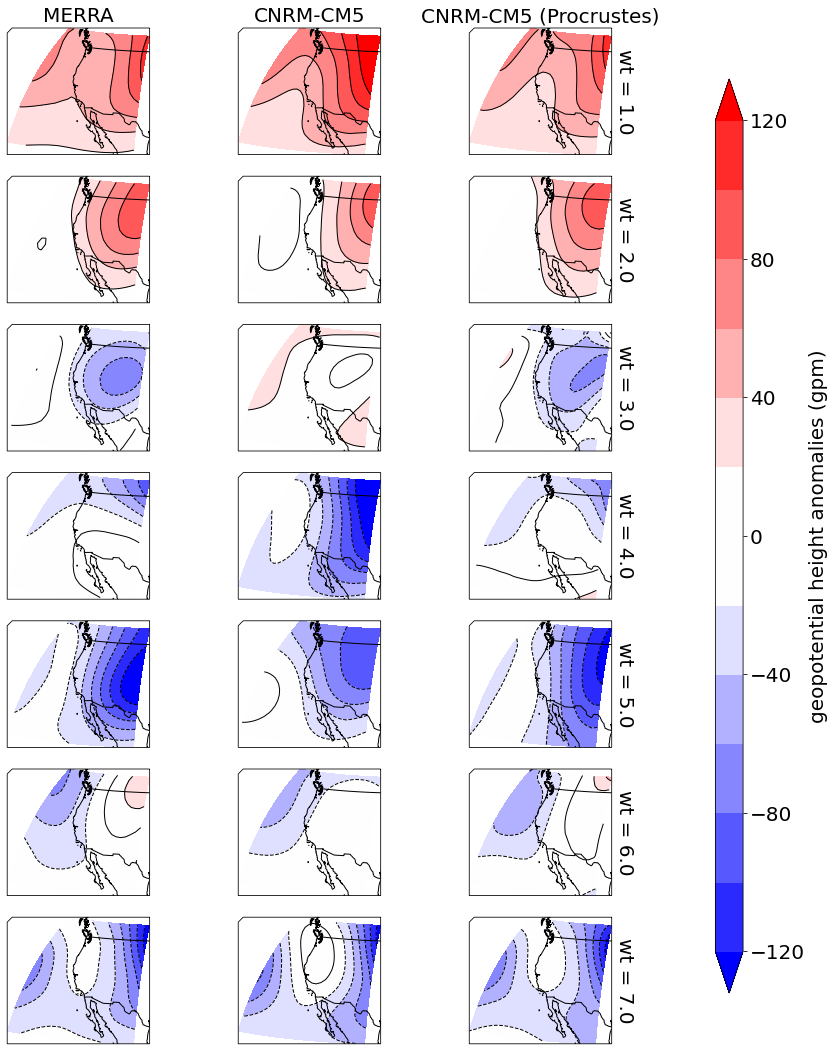

In [25]:
plot_procrustesCorrection(WTf,savefig=False)

## Plot Procrustes decomposition plots

##### Now we use the function which prints a comparison plot showing the callibrated reanalysis data, with the decomposition elements (scaled rotated, tranlated). This plot uses the `procrustes` dataframe which was an output of the `procrustesAnalysis()` function.

##### Set `savefig=True` to save the plot. See function documentation for more information on function parameters.

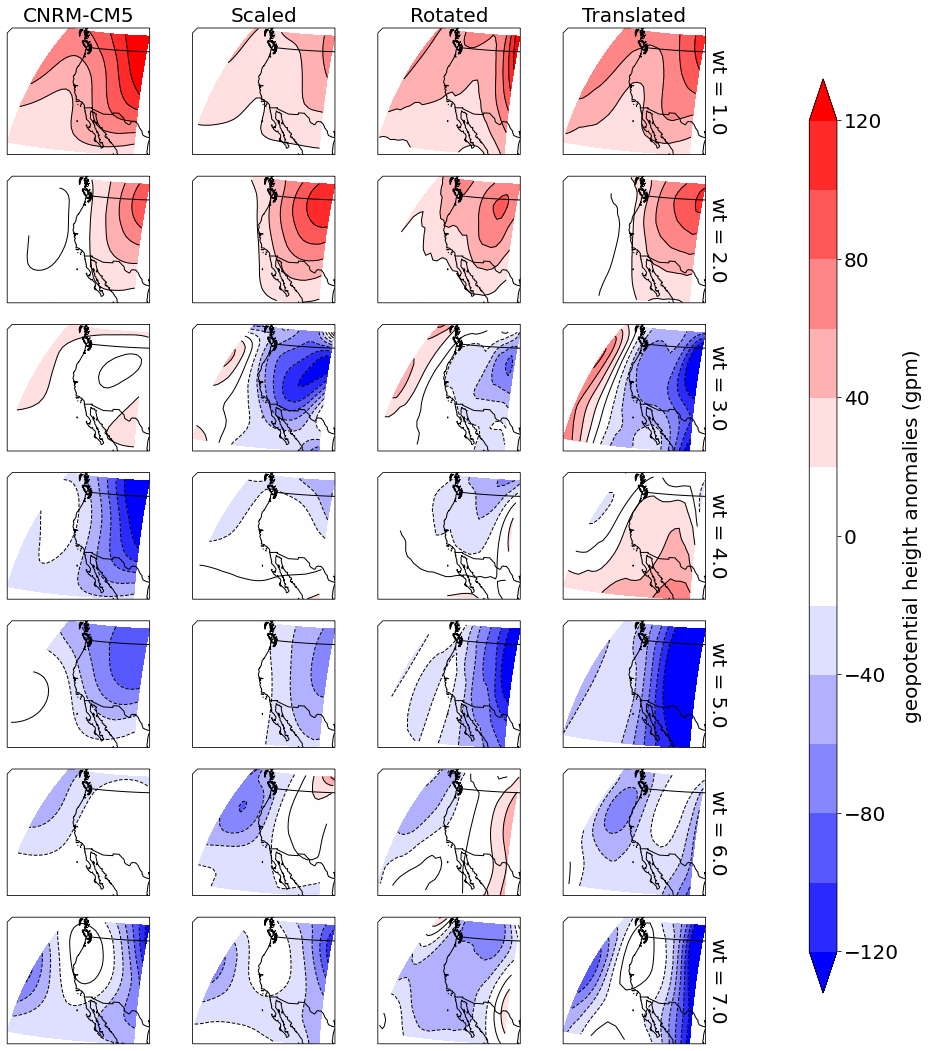

In [26]:
plot_procrustesAnalysis(procrustes,savefig=False)